# ChatGPT-3 v Humans

Performing lexical-semantical analysis of chatGPT-3 and humans

In [1]:
# all imports 
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import re
import unicodedata
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read dataset: stackoverflow v tedx
df = pd.read_csv('/content/drive/MyDrive/ChatGPTvHumans/quora_chatgptVhumans.csv')
# df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.tail()

,question_name,quora,chatgpt,chatgpt_context
61,"What are some amazing facts about Apple, the c...","1) If Apple goes out for shopping, it can buy ...","Here are a few amazing facts about Apple, the ...",there are several interesting and amazing fact...
62,What is the impact of using old equipment on y...,It is undeniable that using old equipment with...,The impact of using old equipment on a company...,using old equipment can have a negative impact...
63,DO you bet the only technology that will becom...,For a while - because everything is being comp...,"As a language model, I do not have the ability...","As Bob, I believe that while computers and cel..."
64,What are the latest trends in the tech industry?,"The tech industry is constantly evolving, with...",There are several trends currently shaping the...,"As of 2023, some of the latest trends in the t..."
65,How do you define technology?,Without technology you can imagine how life is...,Technology can be defined as the application o...,Technology can be defined as the application o...


In [8]:
# drop Prompt
df1 = df.drop('question_name', axis=1)
df_human = df1.drop('chatgpt', axis=1)
df_human = df_human.drop('chatgpt_context', axis=1)
df_chatgpt = df1.drop('quora', axis=1)
df_chatgpt = df_chatgpt.drop('chatgpt_context', axis=1)
df_chatgpt_context = df1.drop('quora', axis=1)
df_chatgpt_context = df_chatgpt_context.drop('chatgpt', axis=1)

In [9]:
df_human.head()

,quora
0,Honestly I think there’s a certain Dunning-Kru...
1,"In general, most large companies tend to have ..."
2,StarLink is a broadband Internet system that h...
3,"Well, let’s start with the definition. A devic..."
4,I find a wide range of services that can be do...


In [10]:
df_chatgpt.head()

,chatgpt
0,"As an AI language model, I don't have the abil..."
1,Big tech companies such as Meta (formerly Face...
2,Starlink is a satellite-based internet service...
3,"As an AI language model, I have a wealth of in..."
4,"As an AI language model, I find many services ..."


In [11]:
df_chatgpt_context.head()

,chatgpt_context
0,"As an AI language model, I am just a tool desi..."
1,Big tech companies have been facing a lot of c...
2,Starlink is a satellite-based internet service...
3,"As an AI language model, I have extensive know..."
4,"As an AI language model, there are many servic..."


In [13]:
# change datatype to string
df_human['quora'] = df_human['quora'].fillna('').astype(str)
df_chatgpt['chatgpt'] = df_chatgpt['chatgpt'].fillna('').astype(str)
df_chatgpt_context['chatgpt_context'] = df_chatgpt_context['chatgpt_context'].fillna('').astype(str)

In [14]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# tested, works
df_human["quora"] = df_human.quora.map(remove_stopwords)
df_chatgpt["chatgpt"] = df_chatgpt.chatgpt.map(remove_stopwords)
df_chatgpt_context["chatgpt_context"] = df_chatgpt_context.chatgpt_context.map(remove_stopwords)

In [17]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

# Unigram model


In [19]:
# run the clean function
# words = basic_clean(''.join(str(df_noSW['Answer'].tolist())))
human_words = basic_clean(''.join(str(df_human['quora'].tolist())))
chatgpt_words = basic_clean(''.join(str(df_chatgpt['chatgpt'].tolist())))
chatgpt_context_words = basic_clean(''.join(str(df_chatgpt_context['chatgpt_context'].tolist())))

## Visualizing 'human words'

In [20]:
unigram = (pd.Series(nltk.ngrams(human_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(human_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(human_words, 3)).value_counts())

In [21]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

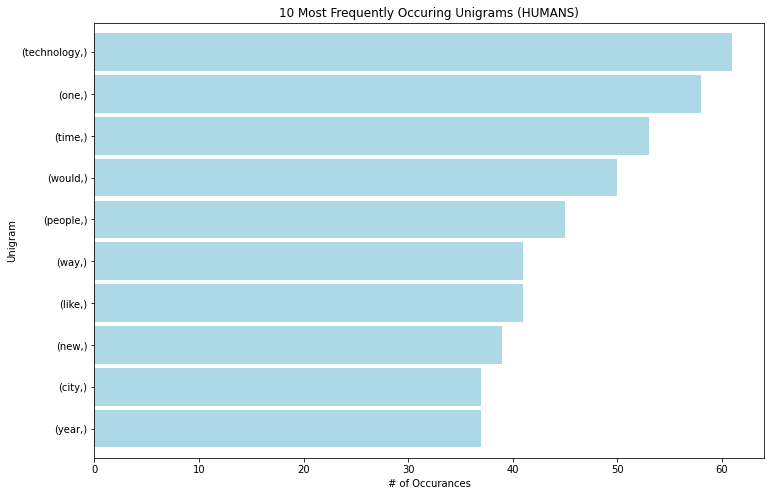

In [22]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (HUMANS)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

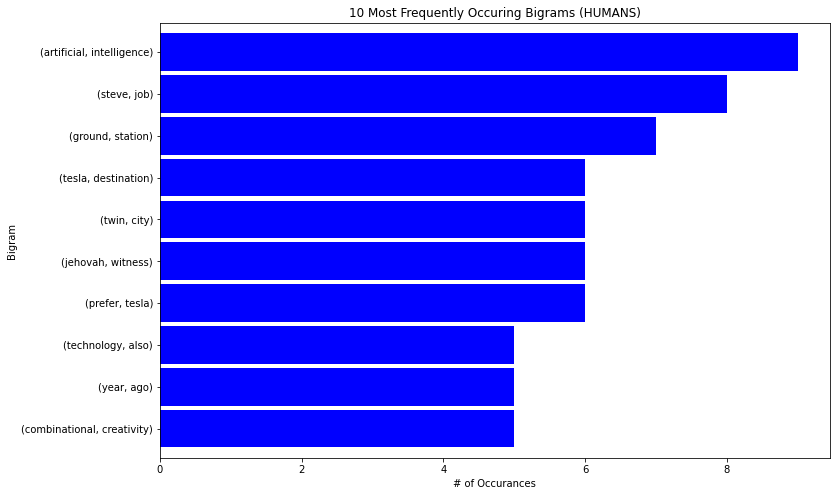

In [23]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

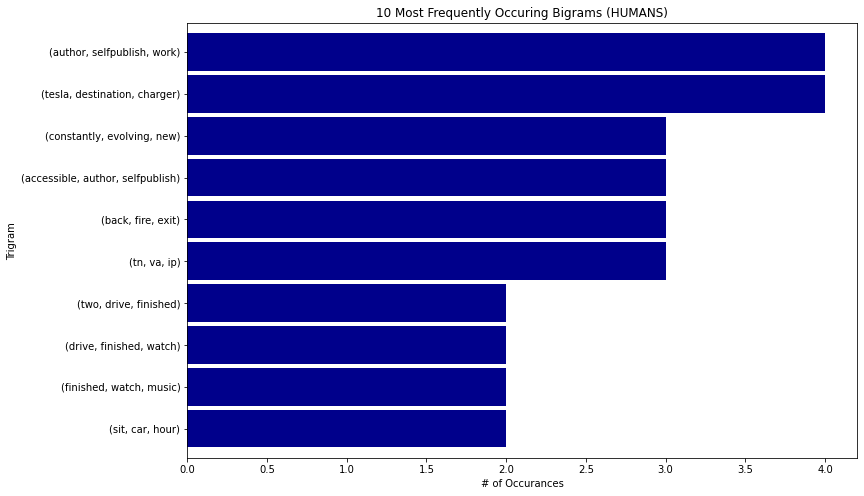

In [24]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## Visualizing 'chatgpt words'

In [25]:
unigram = (pd.Series(nltk.ngrams(chatgpt_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(chatgpt_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(chatgpt_words, 3)).value_counts())

In [26]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

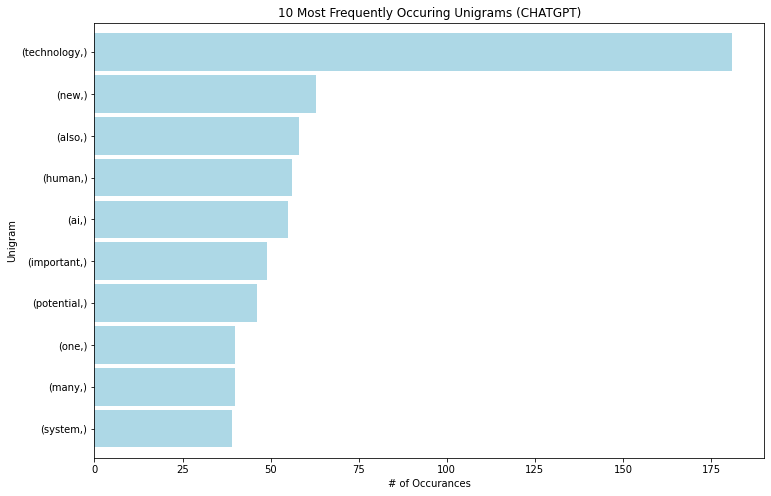

In [27]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (CHATGPT)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

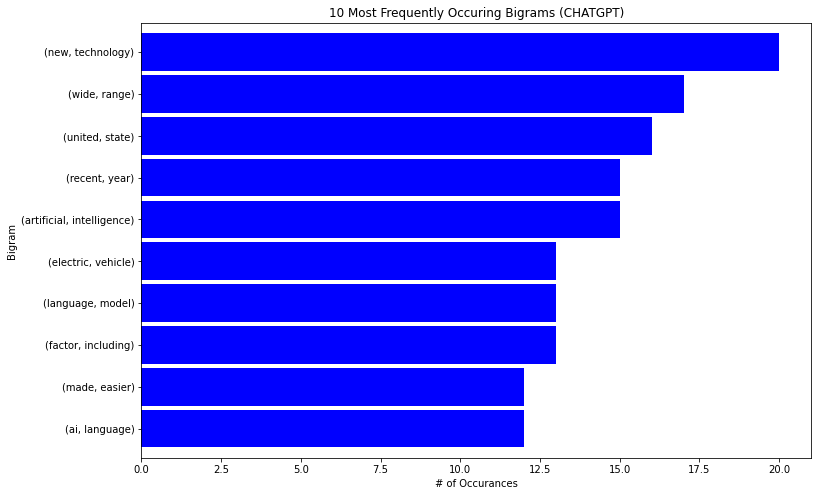

In [28]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

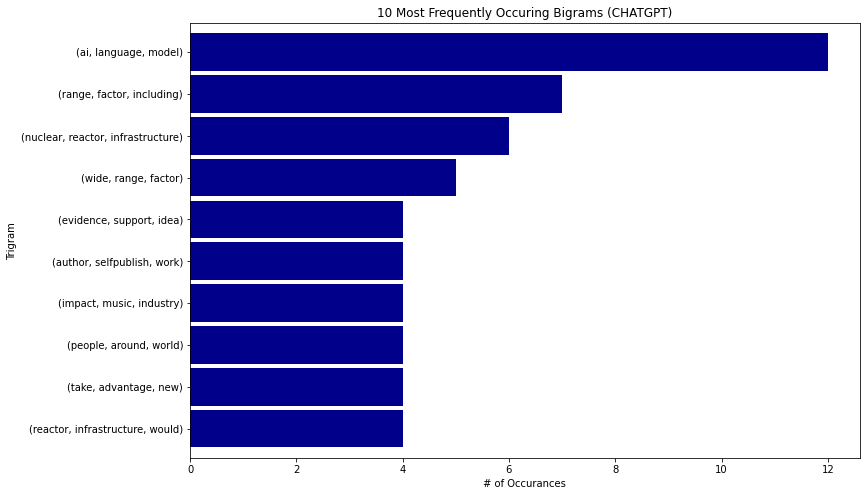

In [29]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## Visualizing 'chatgpt context words'

In [30]:
unigram = (pd.Series(nltk.ngrams(chatgpt_context_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(chatgpt_context_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(chatgpt_context_words, 3)).value_counts())

In [31]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

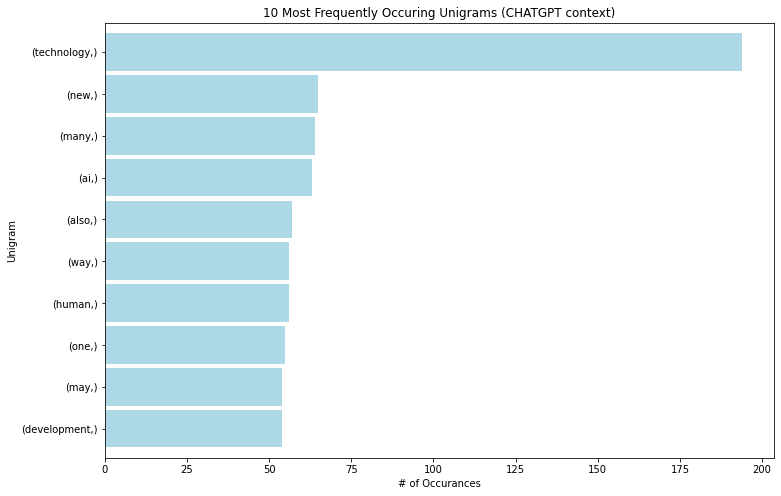

In [32]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (CHATGPT context)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

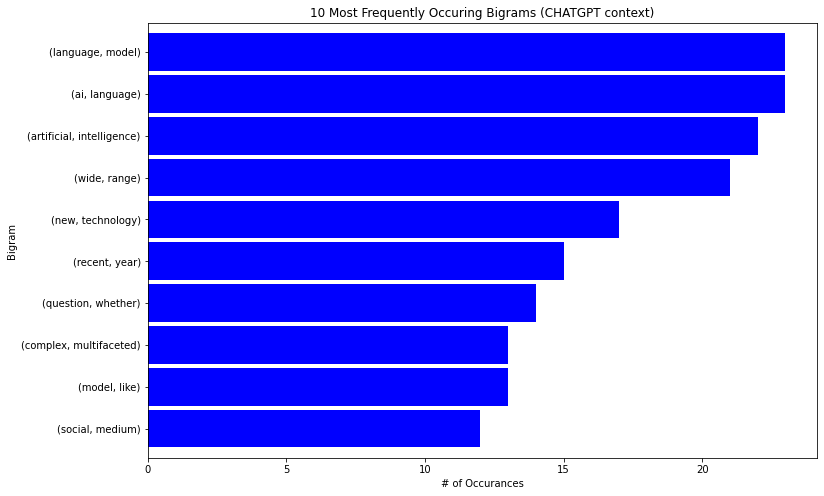

In [33]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT context)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

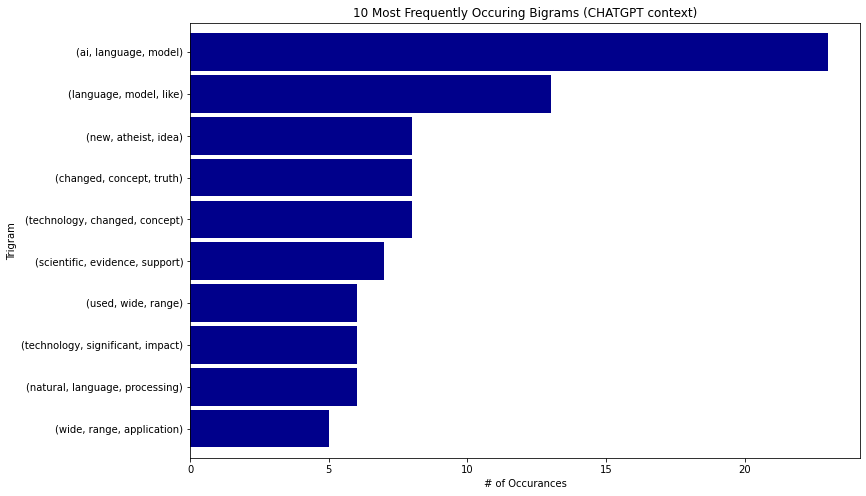

In [34]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT context)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

# Average Text length

In [37]:
# human sentence length
text_column = df_human['quora']
sentences = text_column.apply(nltk.sent_tokenize)
sentence_lengths = sentences.apply(lambda x: [len(sent.split()) for sent in x])
df['sentence_lengths'] = sentence_lengths
average_sentence_length = np.mean([length for lengths in df['sentence_lengths'] for length in lengths])
variance_sentence_length = np.var([length for lengths in df['sentence_lengths'] for length in lengths])
print("average sentence length:", average_sentence_length)
print("variance in sentence length:",variance_sentence_length)

average sentence length: 10.043884220354808
variance in sentence length: 50.538690421702455


In [38]:
# chatgpt sentence length
text_column = df_chatgpt['chatgpt']
sentences = text_column.apply(nltk.sent_tokenize)
sentence_lengths = sentences.apply(lambda x: [len(sent.split()) for sent in x])
df['sentence_lengths'] = sentence_lengths
average_sentence_length = np.mean([length for lengths in df['sentence_lengths'] for length in lengths])
variance_sentence_length = np.var([length for lengths in df['sentence_lengths'] for length in lengths])
print("average sentence length:", average_sentence_length)
print("variance in sentence length:",variance_sentence_length)

average sentence length: 14.76063829787234
variance in sentence length: 30.139514486192844


In [39]:
# chatgpt context sentence length
text_column = df_chatgpt_context['chatgpt_context']
sentences = text_column.apply(nltk.sent_tokenize)
sentence_lengths = sentences.apply(lambda x: [len(sent.split()) for sent in x])
df['sentence_lengths'] = sentence_lengths
average_sentence_length = np.mean([length for lengths in df['sentence_lengths'] for length in lengths])
variance_sentence_length = np.var([length for lengths in df['sentence_lengths'] for length in lengths])
print("average sentence length:", average_sentence_length)
print("variance in sentence length:",variance_sentence_length)

average sentence length: 15.314442413162705
variance in sentence length: 19.08211317172946


## naive

In [ ]:
text_column = df_human['quora']

# initialize variables to store the total number of words and the total number of sentences
total_words = 0
total_sentences = 0

# loop over each row in the text column
for text in text_column:
    # split the text into sentences using a simple rule-based approach
    sentences = text.split('. ')
    # count the number of sentences and add it to the total
    num_sentences = len(sentences)
    total_sentences += num_sentences
    # count the number of words in each sentence and add it to the total
    for sentence in sentences:
        words = sentence.split()
        num_words = len(words)
        total_words += num_words

# calculate the average sentence length by dividing the total number of words by the total number of sentences
average_sentence_length = total_words / total_sentences
print(average_sentence_length)

17.59880239520958


In [ ]:
text_column = df_chatgpt['chatgpt']

# initialize variables to store the total number of words and the total number of sentences
total_words = 0
total_sentences = 0

# loop over each row in the text column
for text in text_column:
    # split the text into sentences using a simple rule-based approach
    sentences = text.split('. ')
    # count the number of sentences and add it to the total
    num_sentences = len(sentences)
    total_sentences += num_sentences
    # count the number of words in each sentence and add it to the total
    for sentence in sentences:
        words = sentence.split()
        num_words = len(words)
        total_words += num_words

# calculate the average sentence length by dividing the total number of words by the total number of sentences
average_sentence_length = total_words / total_sentences
print(average_sentence_length)

15.835164835164836


## Visualize sentence length

Text(0.5, 0, 'String')

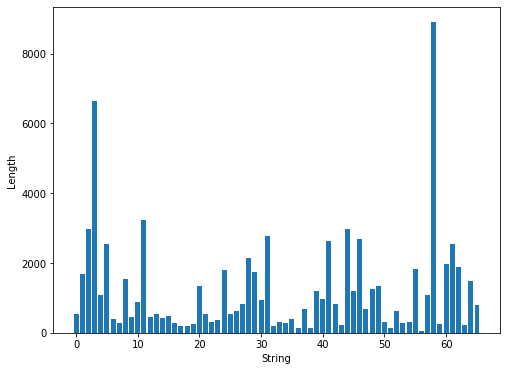

In [40]:
# create an array of strings
string_array = df_human['quora']

# calculate the length of each string in the array
string_lengths = [len(s) for s in string_array]

fig = plt.figure(figsize=(8, 6))
# plot a bar chart of the string lengths
plt.bar(range(len(string_lengths)), string_lengths)
# plt.xticks(range(len(string_lengths)), string_array)
plt.ylabel("Length")
plt.xlabel("String")

Text(0.5, 0, 'String')

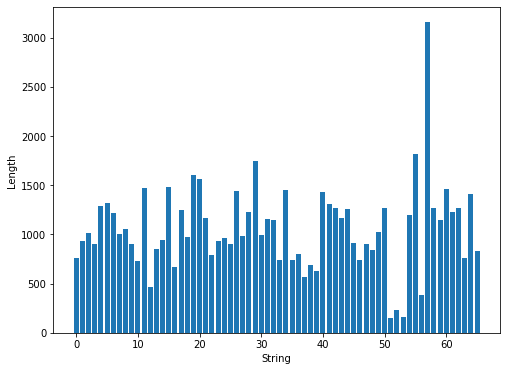

In [41]:
# create an array of strings
string_array = df_chatgpt['chatgpt']

# calculate the length of each string in the array
string_lengths = [len(s) for s in string_array]

fig = plt.figure(figsize=(8, 6))
# plot a bar chart of the string lengths
plt.bar(range(len(string_lengths)), string_lengths)
# plt.xticks(range(len(string_lengths)), string_array)
plt.ylabel("Length")
plt.xlabel("String")

Text(0.5, 0, 'String')

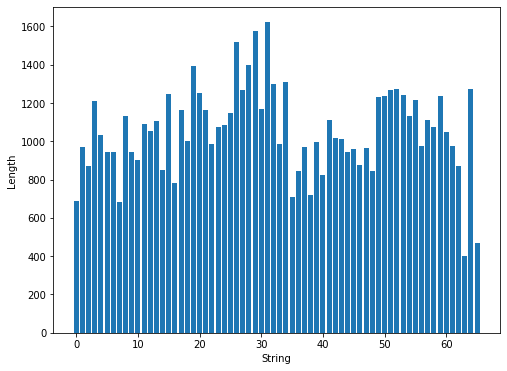

In [42]:
# create an array of strings
string_array = df_chatgpt_context['chatgpt_context']

# calculate the length of each string in the array
string_lengths = [len(s) for s in string_array]

fig = plt.figure(figsize=(8, 6))
# plot a bar chart of the string lengths
plt.bar(range(len(string_lengths)), string_lengths)
# plt.xticks(range(len(string_lengths)), string_array)
plt.ylabel("Length")
plt.xlabel("String")